In [1]:
#필요한 모드 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from keras_preprocessing.image import ImageDataGenerator
from pathlib import Path

In [2]:
dir_ = Path('C:/Users/sbrrd/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TL1/개/안구/일반')
test_dir_ = Path('C:/Users/sbrrd/Desktop/153.반려동물 안구질환 데이터/01.데이터/2.Validation/원천데이터/VS/개/안구/일반/')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
test_files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))
    test_files_grabbed.extend(test_dir_.glob(files))

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(files_grabbed)
test_df = proc_img(test_files_grabbed)
df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,유루증
1,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,핵경화
2,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,유루증
3,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,결막염
4,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [3]:
test_df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,핵경화
1,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,유루증
2,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,비궤양성각막질환
3,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
4,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [4]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}\n')

#데이터 라벨링된 결과
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')

Number of pictures: 147526

Number of different labels: 9

Labels: ['유루증' '핵경화' '결막염' '무' '궤양성각막질환' '안검염' '색소침착성각막염' '비궤양성각막질환' '백내장']

Number of pictures: 18458

Number of different labels: 9

Labels: ['핵경화' '유루증' '비궤양성각막질환' '백내장' '무' '색소침착성각막염' '궤양성각막질환' '결막염' '안검염']


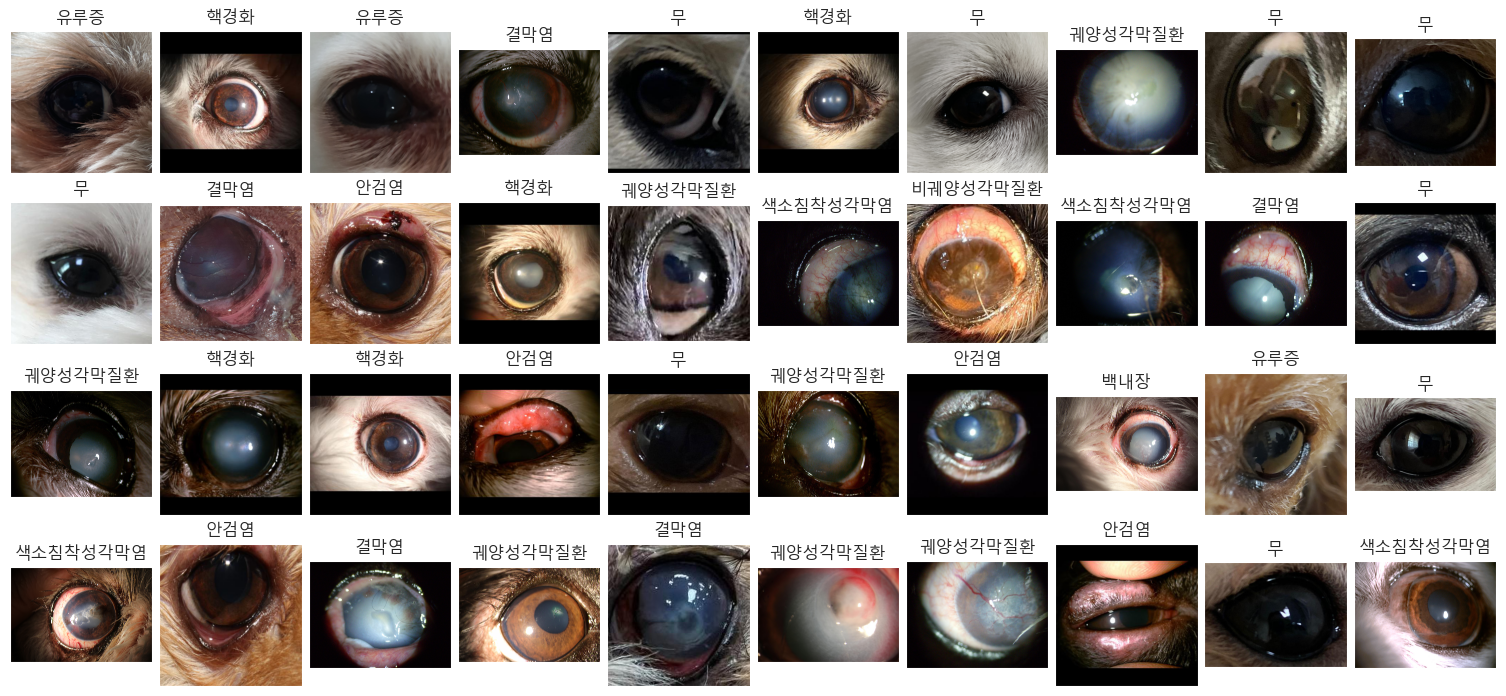

In [5]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

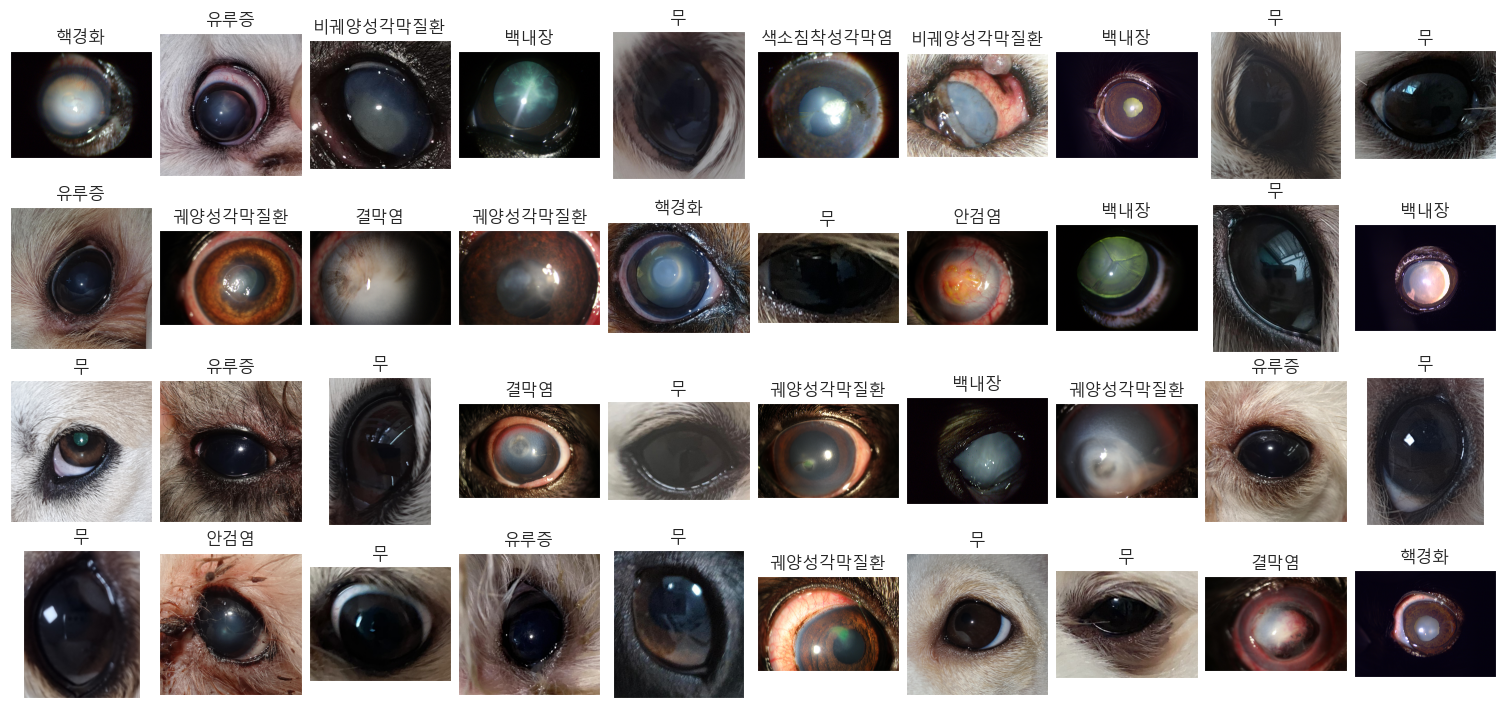

In [6]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(test_df.Filepath[i]))
    ax.set_title(test_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

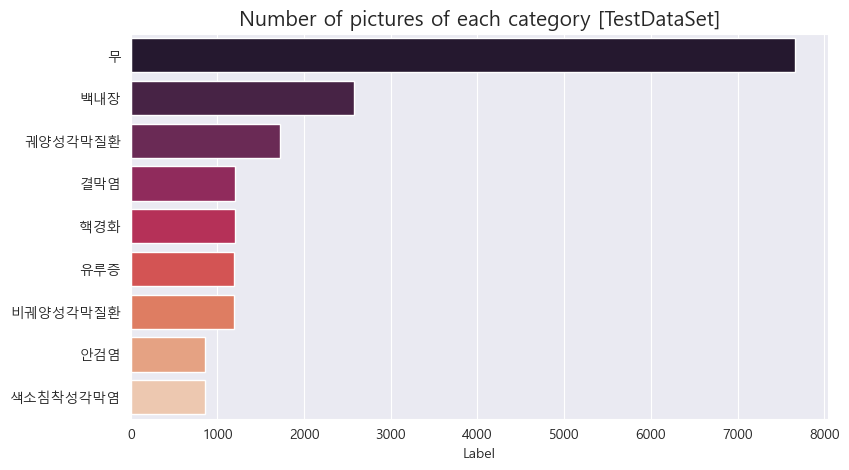

In [7]:
vc = test_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TestDataSet]", fontsize = 15)
plt.show()

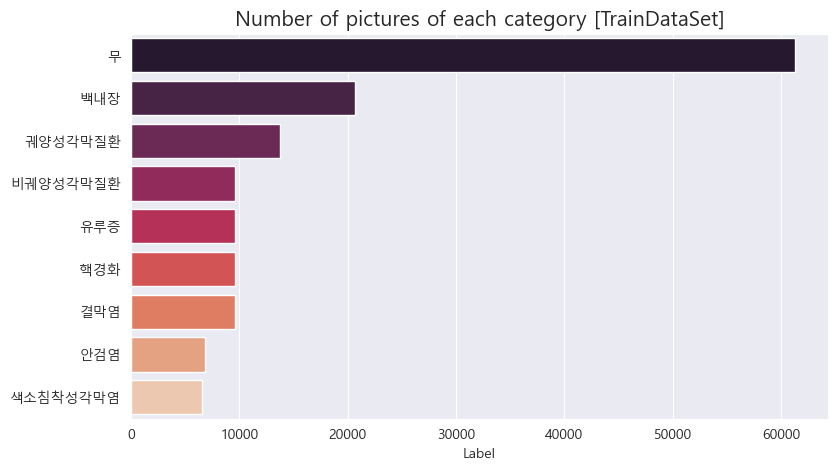

In [8]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TrainDataSet]", fontsize = 15)
plt.show()

In [3]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    x = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
    outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)
    model.compile(
        # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
# tf.keras.applications.DenseNet201

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='model_v7.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]


train_generator,test_generator,train_images,val_images,test_images=create_gen()



with tf.device('/device:GPU:0'):

    model = get_model(tf.keras.applications.DenseNet201)
    history = model.fit(train_images,validation_data=val_images,epochs=10,callbacks=callbacks)

3689/3689 [==============================] - 4765s 1s/step - loss: 0.6807 - accuracy: 0.7329 - val_loss: 0.6387 - val_accuracy: 0.7449
Epoch 2/10
3689/3689 [==============================] - 4341s 1s/step - loss: 0.5957 - accuracy: 0.7588 - val_loss: 0.5689 - val_accuracy: 0.7668
Epoch 3/10
3689/3689 [==============================] - 4329s 1s/step - loss: 0.5629 - accuracy: 0.7719 - val_loss: 0.5726 - val_accuracy: 0.7673
Epoch 4/10
3689/3689 [==============================] - 4297s 1s/step - loss: 0.5402 - accuracy: 0.7777 - val_loss: 0.5858 - val_accuracy: 0.7635
Epoch 5/10
3689/3689 [==============================] - 4221s 1s/step - loss: 0.5216 - accuracy: 0.7837 - val_loss: 0.5448 - val_accuracy: 0.7730
Epoch 6/10
3689/3689 [==============================] - 4291s 1s/step - loss: 0.5067 - accuracy: 0.7894 - val_loss: 0.5490 - val_accuracy: 0.7743
Epoch 7/10
3689/3689 [==============================] - 4418s 1s/step - loss: 0.4940 - accuracy: 0.7928 - val_loss: 0.5492 - val_accura

In [7]:
from keras.saving.save import load_model
train_generator,test_generator,train_images,val_images,test_images=create_gen()
model = load_model('model_v7.h5')
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
model.summary()

Found 118021 validated image filenames belonging to 9 classes.
Found 29505 validated image filenames belonging to 9 classes.
Found 18458 validated image filenames belonging to 9 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
      

577/577 [==============================] - 628s 1s/step
Accuracy on the test set: 64.10%
              precision    recall  f1-score   support

         결막염       0.27      0.11      0.16      1203
     궤양성각막질환       0.37      0.56      0.45      1727
           무       0.98      0.93      0.95      7663
         백내장       0.60      0.71      0.65      2575
    비궤양성각막질환       0.21      0.60      0.31      1186
    색소침착성각막염       0.22      0.07      0.10       852
         안검염       0.28      0.02      0.03       858
         유루증       0.73      0.83      0.77      1196
         핵경화       0.12      0.00      0.00      1198

    accuracy                           0.64     18458
   macro avg       0.42      0.42      0.38     18458
weighted avg       0.63      0.64      0.62     18458



C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.draw()
C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47561 (\N{HANGUL SYLLABLE MAG}) missing from current font.
  fig.canvas.draw()
C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50684 (\N{HANGUL SYLLABLE YEOM}) missing from current font.
  fig.canvas.draw()
C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44452 (\N{HANGUL SYLLABLE GWE}) missing from current font.
  fig.canvas.draw()
C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.draw()
C:\Users\sbrrd\anaconda3\envs\eye_diag_venv\lib\site-packages\seaborn\utils.py:80: UserWarn

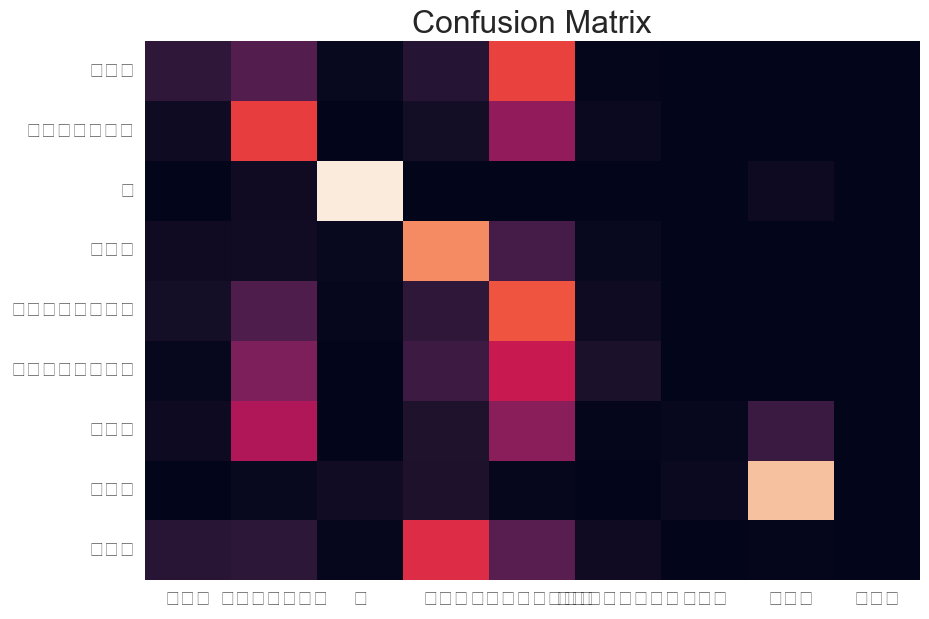

In [8]:
from sklearn.metrics import classification_report,accuracy_score
import numpy as np
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = train_images.class_indices
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')


class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
model.save('model_v7.h5')

In [ ]:
#정확도
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.show()

In [ ]:
#손실도
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()